In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tubesml.base import BaseTransformer, self_columns, reset_columns
import tubesml as tml

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from source import explore as ex
from source import utility as ut

pd.set_option('max_columns', 100)

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
subs = pd.read_csv('data/sample_submission.csv')

In [3]:
train_set, test_set = ut.make_test(df_train, 0.25, random_state=516, strat_feat='cat9')

# PCA

In [4]:
class PCADf(BaseTransformer):
    def __init__(self, n_components, svd_solver='auto', random_state=24, compress=False):
        super().__init__()
        self.n_components = n_components
        self.svd_solver = svd_solver
        self.n_components_ = 0
        self.random_state = random_state
        self.PCA = PCA(n_components=self.n_components, svd_solver=self.svd_solver, random_state=self.random_state)
        self.compress = compress
        self.original_columns = []
        
    @reset_columns
    def fit(self, X, y=None):
        
        self.PCA.fit(X)
        self.n_components_ = self.PCA.n_components_
        
        return self
    
    @self_columns
    def transform(self, X, y=None):
                
        X_tr = self.PCA.transform(X)
        X_tr = pd.DataFrame(X_tr, columns=[f'pca_{i}' for i in range(self.n_components_)])
        
        self.original_columns = X.columns
        
        if self.compress:
            X_tr = self.inverse_transform(X_tr)
        
        return X_tr
    
    
    def inverse_transform(self, X, y=None):
        
        try:
            X_tr = self.PCA.inverse_transform(X)
        except ValueError:
            return X
        X_tr = pd.DataFrame(X_tr, columns=self.original_columns)
        
        return X_tr

In [20]:
mock_pipe = Pipeline([('dums', tml.Dummify(drop_first=True)), 
                          ('pca', PCADf(n_components=0.9))])

tmp = train_set.copy().drop(['id', 'target'], axis=1)

mock_pipe.fit(tmp)

mock_pipe.transform(tmp).head()

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23
0,1.399252,-0.193452,0.659555,0.133527,0.724849,0.288724,-0.552730,-0.251648,-0.129001,-0.030581,-0.111676,-0.064900,0.055690,-0.558035,-0.094349,-0.063656,-0.046720,0.144025,-0.304756,-0.037058,-0.028620,-0.045072,-0.083729,0.036070
1,0.492267,-0.502691,0.740778,0.086588,0.471026,0.152128,-0.263158,-0.138662,-0.138451,-0.317001,-0.069246,-0.146683,-0.073457,-0.085842,0.297234,0.104347,-0.013211,0.063262,0.502187,0.095216,0.092025,0.110734,-0.129220,0.176038
2,1.121375,0.586684,-0.564468,-0.202779,0.317652,0.333011,-0.559419,-0.102401,0.190117,-0.149130,-0.097721,0.330397,0.800583,0.597313,-0.306794,-0.080349,0.524119,-0.148126,-0.101601,-0.206475,-0.730231,0.233357,0.012695,-0.214151
3,0.734584,0.707464,-0.674975,0.127395,0.248047,0.144792,-0.622972,0.636455,-0.136923,0.460282,-0.030045,0.250357,-0.085530,0.110035,-0.528966,-0.052736,-0.126853,0.013656,-0.383771,0.095812,0.090170,0.114255,-0.032302,0.042303
4,-0.704793,-0.766304,0.130601,-0.006218,-0.435156,0.674669,-0.018368,-0.061528,-0.043590,0.171892,-0.153579,-0.088971,0.102045,-0.501080,-0.163715,0.185110,-0.082910,0.408243,-0.203113,0.192492,0.098540,0.121648,-0.029765,0.258386


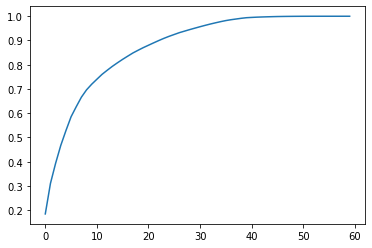

In [22]:
mock_pipe = Pipeline([('dums', tml.Dummify(drop_first=True)), 
                          ('pca', PCADf(n_components=60))])

tmp = train_set.copy().drop(['id', 'target'], axis=1)

mock_pipe.fit(tmp)

plt.plot(np.cumsum(mock_pipe.steps[-1][1].PCA.explained_variance_ratio_))

plt.show()

In [7]:
class TargetEncoder(BaseTransformer):
    # Heavily inspired by 
    # https://github.com/MaxHalford/xam/blob/93c066990d976c7d4d74b63fb6fb3254ee8d9b48/xam/feature_extraction/encoding/bayesian_target.py#L8
    def __init__(self, to_encode=None, prior_weight=100, agg_func='mean'):
        super().__init__()
        if isinstance(to_encode, str):
            self.to_encode = [to_encode]
        else:
            self.to_encode = to_encode
        self.prior_weight = prior_weight
        self.prior_ = None
        self.posteriors_ = None
        self.agg_func = agg_func
     
    
    @reset_columns
    def fit(self, X, y):
        # Encode all categorical cols by default
        if self.to_encode is None:
            self.to_encode = [c for c in X if str(X[c].dtype)=='object' or str(X[c].dtype)=='category']
        
        tmp = X.copy()
        tmp['target'] = y
        
        self.prior_ = tmp['target'].agg(self.agg_func)
        self.posteriors_ = {}
        
        for col in self.to_encode:
            
            agg = tmp.groupby(col)['target'].agg(['count', self.agg_func])
            counts = agg['count']
            data = agg[self.agg_func]
            pw = self.prior_weight
            self.posteriors_[col] = ((pw * self.prior_ + counts * data) / (pw + counts)).to_dict()
        
        del tmp
        return self
    
    
    @self_columns
    def transform(self, X, y=None):
        
        X_tr = X.copy()
        
        for col in self.to_encode:
            X_tr[col] = X_tr[col].map(self.posteriors_[col]).fillna(self.prior_).astype(float)
        
        return X_tr

In [8]:
tmp = train_set.copy().drop(['id', 'target'], axis=1)

trs = TargetEncoder(to_encode=None)

trs.fit_transform(tmp, train_set['target']).head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
217278,7.469369,7.359077,7.430499,7.386198,7.456543,7.477078,7.44936,7.452978,7.330328,7.481622,0.992968,0.062644,0.137455,0.771707,0.494401,0.889793,0.477072,0.777355,0.894772,0.832945,0.528586,0.712178,0.876089,0.594609
168076,7.469369,7.359077,7.430499,7.386198,7.456543,7.446214,7.44936,7.452978,7.479692,7.481622,0.706340,0.297613,0.574490,0.685358,0.280016,0.980636,0.875379,0.650188,0.210627,0.543731,0.551951,0.821223,0.898238,0.422612
85899,7.272367,7.573288,7.430499,7.498261,7.456543,7.477078,7.44936,7.452978,7.330328,7.480117,0.735604,0.770009,0.350257,0.561776,0.266121,0.918674,0.828429,0.345399,0.901242,0.759109,0.726503,0.637654,0.901267,0.729128
66230,7.469369,7.573288,7.430499,7.498261,7.456543,7.477078,7.44936,7.452978,7.330328,7.327223,0.855760,0.617747,0.145037,0.218510,0.677832,0.520412,0.304368,0.676240,0.862597,0.153856,0.177909,0.848022,0.311321,0.766169
202344,7.469369,7.359077,7.430499,7.498261,7.456543,7.462663,7.44936,7.452978,7.447371,7.481622,0.397990,0.069838,0.452991,0.174816,0.775703,0.305720,0.349109,0.702810,0.304682,0.441488,0.240995,0.381703,0.302658,0.719237


In [9]:
tmp = train_set.copy().drop(['id', 'target'], axis=1)

trs = TargetEncoder(to_encode=None, agg_func='skew')

trs.fit_transform(tmp, train_set['target']).head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
217278,-0.219751,-0.184853,-0.198397,-0.274259,-0.203186,-0.282667,-0.202641,-0.191662,-0.213017,-0.360978,0.992968,0.062644,0.137455,0.771707,0.494401,0.889793,0.477072,0.777355,0.894772,0.832945,0.528586,0.712178,0.876089,0.594609
168076,-0.219751,-0.184853,-0.198397,-0.274259,-0.203186,0.013744,-0.202641,-0.191662,-0.167824,-0.360978,0.706340,0.297613,0.574490,0.685358,0.280016,0.980636,0.875379,0.650188,0.210627,0.543731,0.551951,0.821223,0.898238,0.422612
85899,-0.005541,-0.269103,-0.198397,-0.163056,-0.203186,-0.282667,-0.202641,-0.191662,-0.213017,-0.095368,0.735604,0.770009,0.350257,0.561776,0.266121,0.918674,0.828429,0.345399,0.901242,0.759109,0.726503,0.637654,0.901267,0.729128
66230,-0.219751,-0.269103,-0.198397,-0.163056,-0.203186,-0.282667,-0.202641,-0.191662,-0.213017,0.012406,0.855760,0.617747,0.145037,0.218510,0.677832,0.520412,0.304368,0.676240,0.862597,0.153856,0.177909,0.848022,0.311321,0.766169
202344,-0.219751,-0.184853,-0.198397,-0.163056,-0.203186,-0.127018,-0.202641,-0.191662,-0.193997,-0.360978,0.397990,0.069838,0.452991,0.174816,0.775703,0.305720,0.349109,0.702810,0.304682,0.441488,0.240995,0.381703,0.302658,0.719237


In [10]:
tmp = train_set.copy().drop(['id', 'target'], axis=1)

trs = TargetEncoder(to_encode=None, agg_func='std')

trs.fit_transform(tmp, train_set['target']).head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
217278,0.887392,0.861619,0.881632,0.898826,0.886884,0.908026,0.885521,0.884859,0.915001,0.905381,0.992968,0.062644,0.137455,0.771707,0.494401,0.889793,0.477072,0.777355,0.894772,0.832945,0.528586,0.712178,0.876089,0.594609
168076,0.887392,0.861619,0.881632,0.898826,0.886884,0.872438,0.885521,0.884859,0.894407,0.905381,0.706340,0.297613,0.574490,0.685358,0.280016,0.980636,0.875379,0.650188,0.210627,0.543731,0.551951,0.821223,0.898238,0.422612
85899,0.859443,0.902390,0.881632,0.877783,0.886884,0.908026,0.885521,0.884859,0.915001,0.854866,0.735604,0.770009,0.350257,0.561776,0.266121,0.918674,0.828429,0.345399,0.901242,0.759109,0.726503,0.637654,0.901267,0.729128
66230,0.887392,0.902390,0.881632,0.877783,0.886884,0.908026,0.885521,0.884859,0.915001,0.863877,0.855760,0.617747,0.145037,0.218510,0.677832,0.520412,0.304368,0.676240,0.862597,0.153856,0.177909,0.848022,0.311321,0.766169
202344,0.887392,0.861619,0.881632,0.877783,0.886884,0.861336,0.885521,0.884859,0.889007,0.905381,0.397990,0.069838,0.452991,0.174816,0.775703,0.305720,0.349109,0.702810,0.304682,0.441488,0.240995,0.381703,0.302658,0.719237


In [4]:
class CatSimp(BaseTransformer):
    def __init__(self, cat7=True, cat6=True, cat8=True, cat4=True, cat9=True):
        super().__init__()
        self.cat7 = cat7
        self.cat6 = cat6
        self.cat8 = cat8
        self.cat4 = cat4
        self.cat9 = cat9
     
    
    def cat7_tr(self, X):
        X_tr = X.copy()
        
        if self.cat7:
            X_tr['cat7'] = X_tr['cat7'].map({'C': 'E', 
                                             'A': 'B', 
                                             'F': 'G', 
                                             'I': 'G'}).fillna(X_tr['cat7'])
        
        return X_tr
    
    
    def cat6_tr(self, X):
        X_tr = X.copy()
        
        if self.cat6:
            X_tr.loc[X_tr['cat6'] != 'A', 'cat6'] = 'B'
        
        return X_tr
    
    
    def cat8_tr(self, X):
        X_tr = X.copy()
        
        if self.cat8:
            X_tr['cat8'] = X_tr['cat8'].map({'B': 'E', 'F': 'E'}).fillna(X_tr['cat8'])
        
        return X_tr
    
    
    def cat4_tr(self, X):
        X_tr = X.copy()
        
        if self.cat4:
            X_tr['cat4'] = X_tr['cat4'].map({'D': 'A'}).fillna(X_tr['cat4'])
        
        return X_tr
    
    
    def cat9_tr(self, X):
        X_tr = X.copy()
        
        if self.cat9:
            X_tr['cat9'] = X_tr['cat9'].map({'E': 'L', 'D': 'J', 'C': 'L'}).fillna(X_tr['cat9'])
        
        return X_tr
    
    @self_columns
    def transform(self, X, y=None):
        
        Xtransf = self.cat7_tr(X)
        Xtransf = self.cat6_tr(Xtransf)
        Xtransf = self.cat8_tr(Xtransf)
        Xtransf = self.cat4_tr(Xtransf)
        Xtransf = self.cat9_tr(Xtransf)
        
        return Xtransf